In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

## 导入数据

In [2]:
train_image_path = glob.glob("./dc_2000/train/*/*.jpg")
len(train_image_path)

2000

In [3]:
train_image_path[:5]

['./dc_2000/train\\cat\\cat.0.jpg',
 './dc_2000/train\\cat\\cat.1.jpg',
 './dc_2000/train\\cat\\cat.10.jpg',
 './dc_2000/train\\cat\\cat.100.jpg',
 './dc_2000/train\\cat\\cat.101.jpg']

In [4]:
p = './dc_2000/train\\cat\\cat.0.jpg'
p.split("\\")

['./dc_2000/train', 'cat', 'cat.0.jpg']

In [5]:
train_image_label = p.split("\\")[-2]
train_image_label

'cat'

In [6]:
int(p.split("\\")[-2] == 'cat')

1

In [7]:
train_image_label = [int(p.split("\\")[-2] == 'cat') for p in train_image_path]
train_image_label[:5]

[1, 1, 1, 1, 1]

## 数据预处理

## 图片增强，测试集不需要

In [8]:
# read dataset and reshape label
def load_preprosess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [360,360])
    image = tf.image.random_crop(image, [256,256,3])   # 随机剪切
    image = tf.image.random_flip_up_down(image)  # 随机翻转
    image = tf.image.random_flip_left_right(image)
    # 效果不明显
    image = tf.image.random_brightness(image, 10)
    image = tf.image.random_contrast(image, lower=0.2, upper=0.8)
    image = tf.cast(image, tf.float32)
    image = image/255
    label = tf.reshape(label, [1])
    return image, label

In [ ]:
# read dataset and reshape label
def load_test_preprosess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256,256])
    image = tf.cast(image, tf.float32)
    image = image/255
    label = tf.reshape(label, [1])
    return image, label

- NOTE
- tf.image.convert_image_dtype 此函数会将数据准换类型并归一化
- [1,2,3] 一个数据
- [[1],[2],[3]] 三个数据

In [9]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path,train_image_label))

In [10]:
# 自动调用并行内存
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [11]:
# 只能运行一次
train_image_ds = train_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)

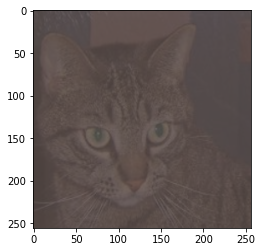

In [16]:
# 这样显示图片，在没有batch中
for img, label in train_image_ds.take(2):
    plt.imshow(img)

In [13]:
# 一次性处理的图片个数，视计算机内存而定
BATCH_SIZE = 64
train_count = len(train_image_path)
train_image_ds = train_image_ds.shuffle(train_count).batch(BATCH_SIZE)

# 自动在后台处理一些数据
train_image_ds = train_image_ds.prefetch(AUTOTUNE)

In [14]:
# 这样显示图片，在batch之后，可迭代对象
# 相当于对tf.data.Dataset.from_tensor_slices 的反向操作
imgs, labels = next(iter(train_image_ds))
imgs.shape, labels.shape
plt.imshow(imgs[0])

(TensorShape([64, 256, 256, 3]), TensorShape([64, 1]))

## 加载测试集

In [29]:
test_image_path = glob.glob("./dc_2000/test/*/*.jpg")
test_image_label = [int(p.split("\\")[-2] == 'cat') for p in test_image_path]
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path,test_image_label))
test_image_ds = test_image_ds.map(load_test_preprosess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.batch(BATCH_SIZE)

# 速度会快一点，在搞清楚是啥前不推荐不推荐
# test_image_ds = test_image_ds.prefetch(AUTOTUNE)

## 创建模型

In [30]:
model = keras.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),input_shape=(256,256,3),activation='relu'),
    tf.keras.layers.BatchNormalization()
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization()
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization()
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization()
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization()
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization()
    tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization()
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(1024,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization()
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization()
    tf.keras.layers.Dense(1)  # 二元分类问题，不需要激活，只用判断x的取值范围即可
])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       5

In [32]:
# 不训练，直接预测，就是瞎猜一下
pred = model(imgs)

In [33]:
np.array([p[0].numpy() for p in tf.cast(pred > 0, tf.int32)])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
np.array([l[0].numpy() for l in labels])

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1])

## 自定义训练模型

In [35]:
# 大写创建一个可以调用的计算二元交叉熵实例
# 参数：from_logits=False 表示激活了
ls = tf.keras.losses.BinaryCrossentropy()

In [36]:
ls([0.,0,1,1],[1.,1,1,1])

<tf.Tensor: shape=(), dtype=float32, numpy=7.6666193>

In [37]:
ls([[0.],[0],[1],[1]],[[1.],[1],[1],[1]])

<tf.Tensor: shape=(), dtype=float32, numpy=7.6666193>

In [38]:
# 小写的binarybrossentropy 直接用
ls_all = tf.keras.losses.binary_crossentropy([[0.],[0],[1],[1]],[[1.],[1],[1],[1]])

In [39]:
tf.keras.losses.binary_crossentropy([0.,0,1,1],[1.,1,1,1])

<tf.Tensor: shape=(), dtype=float32, numpy=7.6666193>

In [40]:
optimizer = tf.keras.optimizers.Adam()

In [41]:
# 定义metrics
# 每一轮训练的平均损失
epoch_loss_avg = tf.keras.metrics.Mean('train_loss')
# 每一轮的正确率
train_accuracy = tf.keras.metrics.Accuracy()

In [42]:
# application
train_accuracy([1,0,1],[1,1,1,])

<tf.Tensor: shape=(), dtype=float32, numpy=0.6666667>

In [43]:
# 进行一步的训练
def train_step(model, images, labels):
    with tf.GradientTape() as t:
        pred = model(images, training=False)   # == pred = model.predict(images)
        loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels,pred)
        
    grads = t.gradient(loss_step, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # 计算一步的平均损失
    epoch_loss_avg(loss_step)
    # 计算一步的平均精度
    train_accuracy(labels,tf.cast(pred>0, tf.int32))

In [44]:
# 进行一步的测试

# 定义metrics
# 每一轮训练的平均损失
epoch_loss_avg_test = tf.keras.metrics.Mean('test_loss')
# 每一轮的正确率
test_accuracy = tf.keras.metrics.Accuracy()

def test_step(model, images, labels):
    pred = model(images)
    loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels,pred)

    # 计算一步的平均损失
    epoch_loss_avg_test(loss_step)
    # 计算一步的平均精度
    test_accuracy(labels,tf.cast(pred>0, tf.int32))

In [45]:
train_loss_results = []
train_acc_results = []

test_loss_results = []
test_acc_results = []

In [46]:
num_epochs = 30

In [ ]:
for epoch in range(num_epochs):
    for imgs_, labels_ in train_image_ds:
        train_step(model, imgs_, labels_)
        # 训练一个batch步返回一个*
        print('*',end="")
    # 训练完一个epoch换行
    print()
    
    train_loss_results.append(epoch_loss_avg.result())
    train_acc_results.append(train_accuracy.result())
    
    for imgs_, labels_ in test_image_ds:
        test_step(model, imgs_, labels_)
    
    test_loss_results.append(epoch_loss_avg_test.result())
    test_acc_results.append(train_accuracy.result())
    
    print('Epoch:{}, loss: {:.3f},accuracy:{:.3f}, test_loss: {:.3f},accuracy:{:.3f}'.format(
        epoch + 1,
        epoch_loss_avg.result(),
        train_accuracy.result(),
        epoch_loss_avg_test.result(),
        test_accuracy.result()
    ))
    
    epoch_loss_avg.reset_states()
    train_accuracy.reset_states()
    epoch_loss_avg_test.reset_states()
    test_accuracy.reset_states()

*